In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os
from datetime import datetime
import sys
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
def reconstruct_annual_mean(trend: xr.DataArray,
                            iav: xr.DataArray,
                            start_year: int = 1901) -> xr.DataArray:
    """
    Reconstruct annual mean time series from 1D trend and 1D IAV files.

    Assumes:
      - trend has dim 'degree' with:
          degree=0 -> intercept
          degree=1 -> slope
      - iav has dim 'time' with length N (annual steps)
      - trend was originally fit on time indices 0..N-1
    """

    # time index for the trend line: 0..N-1
    n_time = iav.sizes["time"]
    t_idx = xr.DataArray(np.arange(n_time), dims=("time",))

    # intercept and slope
    intercept = trend.sel(degree=0)
    slope     = trend.sel(degree=1)

    # trend line
    trend_line = intercept + slope * t_idx
    if trend.name is not None:
        trend_line.name = trend.name.replace("_trend_1D", "_trend_line")
    else:
        trend_line.name = "trend_line"

    # reconstruct annual mean = trend + IAV
    annual_mean = trend_line + iav
    if iav.name is not None:
        annual_mean.name = iav.name.replace("_iav_1D", "_annual_mean")
    else:
        annual_mean.name = "annual_mean"

    # build datetime time axis: 1901-01-01, 1902-01-01, ...
    years = start_year + np.arange(n_time)
    dt = np.array([np.datetime64(f"{y}-01-01") for y in years])

    annual_mean = annual_mean.assign_coords(time=dt)

    # CF-style encoding
    annual_mean.time.encoding.update({
        "units": "days since 1901-01-01",
        "calendar": "noleap",
    })

    return annual_mean

def trend_line_on_time(trend_1d: xr.DataArray,
                       annual_mean: xr.DataArray) -> xr.DataArray:
    """Build trend line on same datetime time axis as annual_mean."""
    n_time = annual_mean.sizes["time"]
    t_idx = xr.DataArray(np.arange(n_time), dims=("time",))

    intercept = trend_1d.sel(degree=0)
    slope     = trend_1d.sel(degree=1)

    line = intercept + slope * t_idx
    # put onto the datetime axis of annual_mean
    line = line.assign_coords(time=annual_mean["time"])
    return line



### Plotting Functions

In [3]:
# load
ensmean_S0_gpp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S0/trend_1D/gpp_trend_1D.nc")
ensmean_S1_gpp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/trend_1D/gpp_trend_1D.nc")
ensmean_S0_gpp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S0/iav_1D/gpp_iav_1D.nc")    
ensmean_S1_gpp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/iav_1D/gpp_iav_1D.nc")
ensmean_S0_gpp_annual_mean = reconstruct_annual_mean(ensmean_S0_gpp_trend, ensmean_S0_gpp_iav, start_year=1901)
ensmean_S1_gpp_annual_mean = reconstruct_annual_mean(ensmean_S1_gpp_trend, ensmean_S1_gpp_iav, start_year=1901)

stable_S0_gpp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S0/full/trend_1D/gpp_trend_1D.nc")
stable_S1_gpp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/trend_1D/gpp_trend_1D.nc")
stable_S0_gpp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S0/full/iav_1D/gpp_iav_1D.nc")    
stable_S1_gpp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/iav_1D/gpp_iav_1D.nc")
stable_S0_gpp_annual_mean = reconstruct_annual_mean(stable_S0_gpp_trend, stable_S0_gpp_iav, start_year=1901)
stable_S1_gpp_annual_mean = reconstruct_annual_mean(stable_S1_gpp_trend, stable_S1_gpp_iav, start_year=1901)

# Build trend lines for each
ens_S0_gpp_line = trend_line_on_time(ensmean_S0_gpp_trend, ensmean_S0_gpp_annual_mean)
ens_S1_gpp_line = trend_line_on_time(ensmean_S1_gpp_trend, ensmean_S1_gpp_annual_mean)
stb_S0_gpp_line = trend_line_on_time(stable_S0_gpp_trend, stable_S0_gpp_annual_mean)
stb_S1_gpp_line = trend_line_on_time(stable_S1_gpp_trend, stable_S1_gpp_annual_mean)

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

In [4]:
import matplotlib.pyplot as plt

# Apply Calibri-like settings globally (DejaVu Sans as fallback)
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})


def plot_two_scenarios(
    # S1 inputs
    ens_S1_annual, ens_S1_trend_coeffs, ens_S1_line,
    stb_S1_annual, stb_S1_trend_coeffs, stb_S1_line,
    # S2 inputs
    ens_S2_annual, ens_S2_trend_coeffs, ens_S2_line,
    stb_S2_annual, stb_S2_trend_coeffs, stb_S2_line,
    var_label: str,
    units: str,
    scen_labels=("S1", "S2"),
    share_y: bool = True,
    markers: bool = False,
):
    """
    Plot ensemble vs stable emulator trends + annual means for two scenarios
    as subplots in a 1×2 figure, with slope annotations and ONE shared 4-item legend.
    """

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=share_y)

    legend_handles = None
    legend_labels = None

    ENS_MARK = "o" if markers else None
    STB_MARK = "s" if markers else None

    def _plot_one(ax, scen_label,
                  ens_annual, ens_trend_coeffs, ens_line,
                  stb_annual, stb_trend_coeffs, stb_line,
                  collect_legend=False):

        h1 = ax.plot(
            ens_annual["time"], ens_annual,
            marker=ENS_MARK, linestyle="-",
            linewidth=1.8, markersize=3.5,
            label="TRENDY-Ensemble Annual Mean",
        )[0]

        h2 = ax.plot(
            ens_line["time"], ens_line,
            linestyle="--",
            linewidth=1.8,
            label="TRENDY-Ensemble Trend",
        )[0]

        h3 = ax.plot(
            stb_annual["time"], stb_annual,
            marker=STB_MARK, linestyle="-",
            linewidth=1.8, markersize=3.5,
            label="Stable-Emulator Annual Mean",
        )[0]

        h4 = ax.plot(
            stb_line["time"], stb_line,
            linestyle="--",
            linewidth=1.8,
            label="Stable-Emulator Trend",
        )[0]

        if collect_legend:
            nonlocal legend_handles, legend_labels
            legend_handles = [h1, h2, h3, h4]
            legend_labels = [h.get_label() for h in legend_handles]

        ax.set_xlabel("Year")

        # ---- UPDATED: bold + 1pt larger ----
        ax.set_title(
            scen_label,
            fontsize=13,
            fontweight="bold"
        )

        ax.grid(True, which="major", alpha=0.3)
        ax.minorticks_on()
        ax.grid(True, which="minor", alpha=0.1, linewidth=0.5)

        for spine in ("top", "right"):
            ax.spines[spine].set_visible(False)

    # Scenario 1
    _plot_one(
        axes[0], scen_labels[0],
        ens_S1_annual, ens_S1_trend_coeffs, ens_S1_line,
        stb_S1_annual, stb_S1_trend_coeffs, stb_S1_line,
        collect_legend=True,
    )
    axes[0].set_ylabel(f"{var_label} ({units})")

    # Scenario 2
    _plot_one(
        axes[1], scen_labels[1],
        ens_S2_annual, ens_S2_trend_coeffs, ens_S2_line,
        stb_S2_annual, stb_S2_trend_coeffs, stb_S2_line,
        collect_legend=False,
    )

    fig.tight_layout(rect=(0.0, 0.08, 1.0, 1.0))

    fig.legend(
        legend_handles,
        legend_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.0),
        ncol=4,
        frameon=False,
    )

    return fig, axes

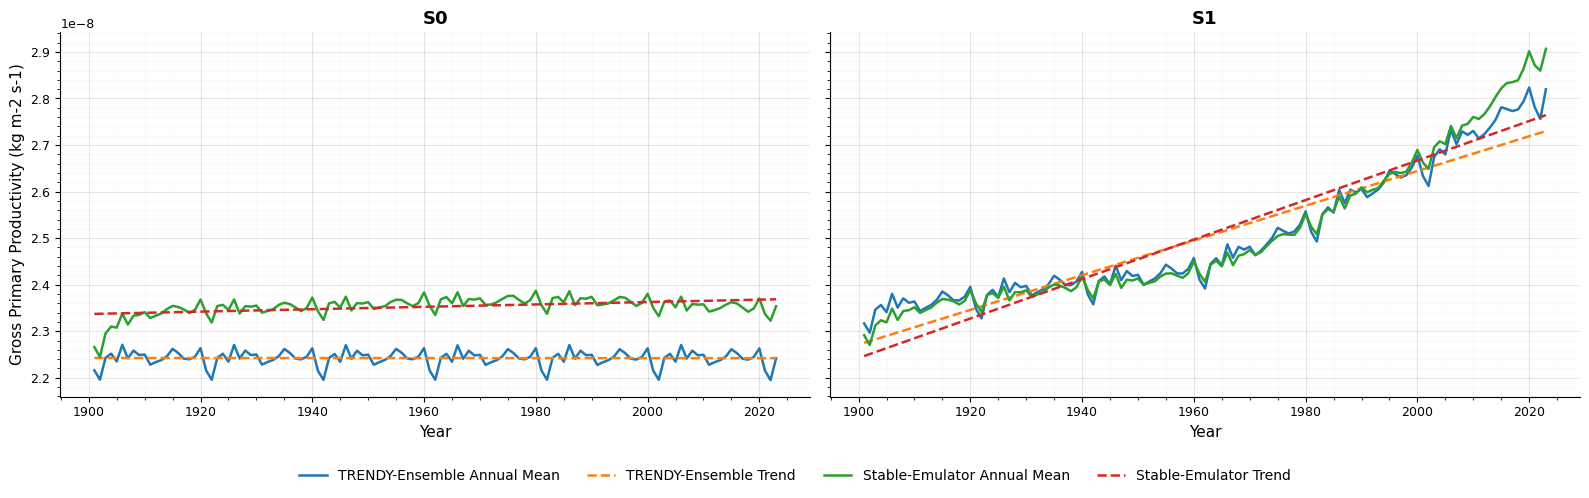

In [5]:
fig, axes = plot_two_scenarios(
    ensmean_S0_gpp_annual_mean, ensmean_S0_gpp_trend, ens_S0_gpp_line,
    stable_S0_gpp_annual_mean, stable_S0_gpp_trend, stb_S0_gpp_line,
    ensmean_S1_gpp_annual_mean, ensmean_S1_gpp_trend, ens_S1_gpp_line,
    stable_S1_gpp_annual_mean, stable_S1_gpp_trend, stb_S1_gpp_line,
    var_label="Gross Primary Productivity",
    units="kg m-2 s-1",
    scen_labels=("S0", "S1"),
)

plt.show()

# S1 to S2

In [6]:
# load gpp
ensmean_S1_gpp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/trend_1D/gpp_trend_1D.nc")
ensmean_S2_gpp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/trend_1D/gpp_trend_1D.nc")
ensmean_S1_gpp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/iav_1D/gpp_iav_1D.nc")    
ensmean_S2_gpp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/iav_1D/gpp_iav_1D.nc")
ensmean_S1_gpp_annual_mean = reconstruct_annual_mean(ensmean_S1_gpp_trend, ensmean_S1_gpp_iav, start_year=1901)
ensmean_S2_gpp_annual_mean = reconstruct_annual_mean(ensmean_S2_gpp_trend, ensmean_S2_gpp_iav, start_year=1901)

stable_S1_gpp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/trend_1D/gpp_trend_1D.nc")
stable_S2_gpp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/trend_1D/gpp_trend_1D.nc")
stable_S1_gpp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/iav_1D/gpp_iav_1D.nc")    
stable_S2_gpp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/iav_1D/gpp_iav_1D.nc")
stable_S1_gpp_annual_mean = reconstruct_annual_mean(stable_S1_gpp_trend, stable_S1_gpp_iav, start_year=1901)
stable_S2_gpp_annual_mean = reconstruct_annual_mean(stable_S2_gpp_trend, stable_S2_gpp_iav, start_year=1901)

# Build trend lines for each
ens_S1_gpp_line = trend_line_on_time(ensmean_S1_gpp_trend, ensmean_S1_gpp_annual_mean)
ens_S2_gpp_line = trend_line_on_time(ensmean_S2_gpp_trend, ensmean_S2_gpp_annual_mean)
stb_S1_gpp_line = trend_line_on_time(stable_S1_gpp_trend, stable_S1_gpp_annual_mean)
stb_S2_gpp_line = trend_line_on_time(stable_S2_gpp_trend, stable_S2_gpp_annual_mean)

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

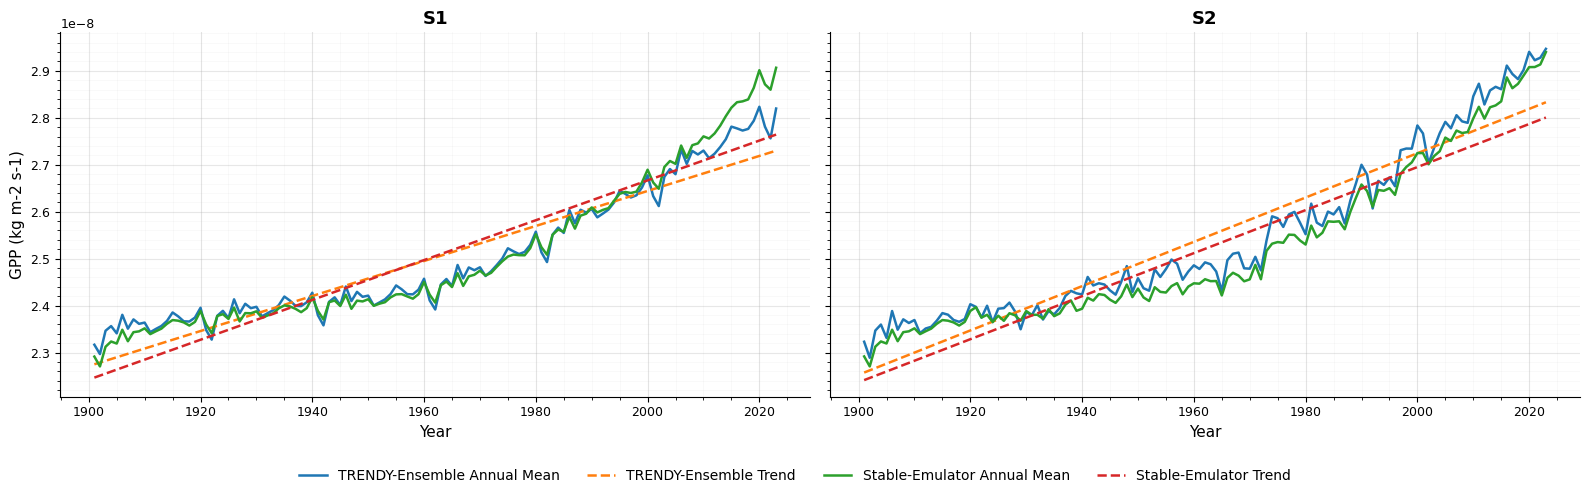

In [7]:
fig, axes = plot_two_scenarios(
    ensmean_S1_gpp_annual_mean, ensmean_S1_gpp_trend, ens_S1_gpp_line,
    stable_S1_gpp_annual_mean, stable_S1_gpp_trend, stb_S1_gpp_line,
    ensmean_S2_gpp_annual_mean, ensmean_S2_gpp_trend, ens_S2_gpp_line,
    stable_S2_gpp_annual_mean, stable_S2_gpp_trend, stb_S2_gpp_line,
    var_label="GPP",
    units="kg m-2 s-1",
    scen_labels=("S1", "S2"),
)

plt.show()

In [8]:
# load rh
ensmean_S1_rh_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/trend_1D/rh_trend_1D.nc")
ensmean_S2_rh_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/trend_1D/rh_trend_1D.nc")
ensmean_S1_rh_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/iav_1D/rh_iav_1D.nc")    
ensmean_S2_rh_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/iav_1D/rh_iav_1D.nc")
ensmean_S1_rh_annual_mean = reconstruct_annual_mean(ensmean_S1_rh_trend, ensmean_S1_rh_iav, start_year=1901)
ensmean_S2_rh_annual_mean = reconstruct_annual_mean(ensmean_S2_rh_trend, ensmean_S2_rh_iav, start_year=1901)

stable_S1_rh_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/trend_1D/rh_trend_1D.nc")
stable_S2_rh_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/trend_1D/rh_trend_1D.nc")
stable_S1_rh_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/iav_1D/rh_iav_1D.nc")    
stable_S2_rh_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/iav_1D/rh_iav_1D.nc")
stable_S1_rh_annual_mean = reconstruct_annual_mean(stable_S1_rh_trend, stable_S1_rh_iav, start_year=1901)
stable_S2_rh_annual_mean = reconstruct_annual_mean(stable_S2_rh_trend, stable_S2_rh_iav, start_year=1901)

# Build trend lines for each
ens_S1_rh_line = trend_line_on_time(ensmean_S1_rh_trend, ensmean_S1_rh_annual_mean)
ens_S2_rh_line = trend_line_on_time(ensmean_S2_rh_trend, ensmean_S2_rh_annual_mean)
stb_S1_rh_line = trend_line_on_time(stable_S1_rh_trend, stable_S1_rh_annual_mean)
stb_S2_rh_line = trend_line_on_time(stable_S2_rh_trend, stable_S2_rh_annual_mean)

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

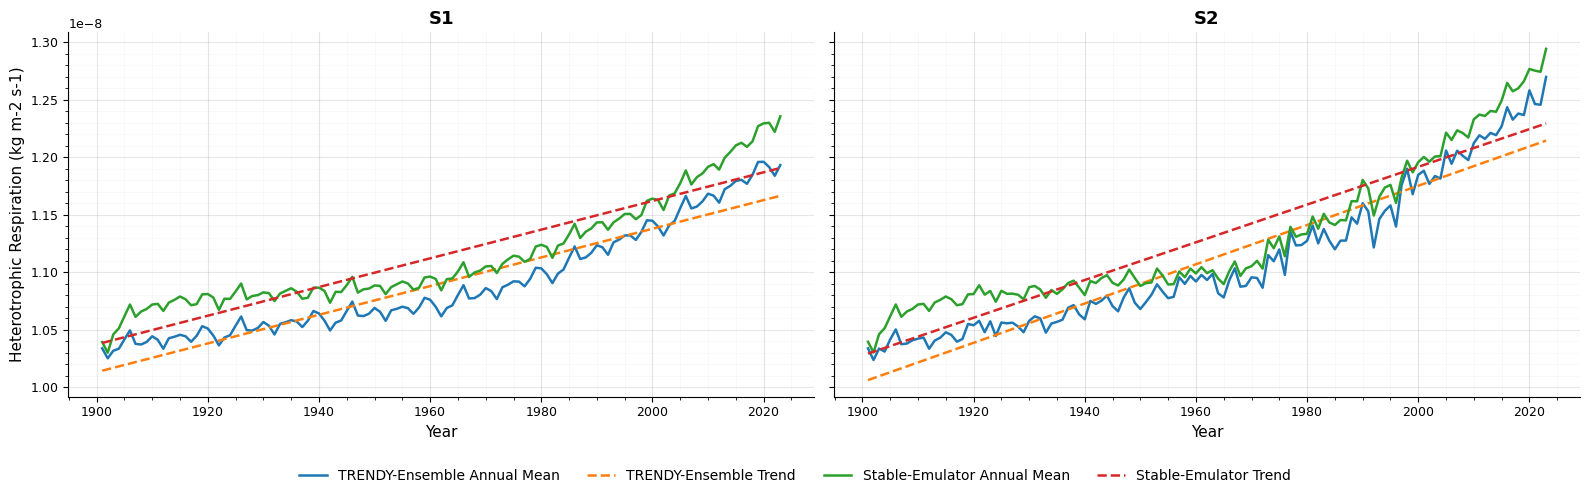

In [9]:
fig, axes = plot_two_scenarios(
    ensmean_S1_rh_annual_mean, ensmean_S1_rh_trend, ens_S1_rh_line,
    stable_S1_rh_annual_mean, stable_S1_rh_trend, stb_S1_rh_line,
    ensmean_S2_rh_annual_mean, ensmean_S2_rh_trend, ens_S2_rh_line,
    stable_S2_rh_annual_mean, stable_S2_rh_trend, stb_S2_rh_line,
    var_label="Heterotrophic Respiration",
    units="kg m-2 s-1",
    scen_labels=("S1", "S2"),
)

plt.show()

# S1-S2 lai

In [10]:
# load evapotrans
ensmean_S1_evapotrans_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/trend_1D/evapotrans_trend_1D.nc")
ensmean_S2_evapotrans_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/trend_1D/evapotrans_trend_1D.nc")
ensmean_S1_evapotrans_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/iav_1D/evapotrans_iav_1D.nc")    
ensmean_S2_evapotrans_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/iav_1D/evapotrans_iav_1D.nc")
ensmean_S1_evapotrans_annual_mean = reconstruct_annual_mean(ensmean_S1_evapotrans_trend, ensmean_S1_evapotrans_iav, start_year=1901)
ensmean_S2_evapotrans_annual_mean = reconstruct_annual_mean(ensmean_S2_evapotrans_trend, ensmean_S2_evapotrans_iav, start_year=1901)

stable_S1_evapotrans_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/trend_1D/evapotrans_trend_1D.nc")
stable_S2_evapotrans_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/trend_1D/evapotrans_trend_1D.nc")
stable_S1_evapotrans_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/iav_1D/evapotrans_iav_1D.nc")    
stable_S2_evapotrans_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/iav_1D/evapotrans_iav_1D.nc")
stable_S1_evapotrans_annual_mean = reconstruct_annual_mean(stable_S1_evapotrans_trend, stable_S1_evapotrans_iav, start_year=1901)
stable_S2_evapotrans_annual_mean = reconstruct_annual_mean(stable_S2_evapotrans_trend, stable_S2_evapotrans_iav, start_year=1901)

# Build trend lines for each
ens_S1_evapotrans_line = trend_line_on_time(ensmean_S1_evapotrans_trend, ensmean_S1_evapotrans_annual_mean)
ens_S2_evapotrans_line = trend_line_on_time(ensmean_S2_evapotrans_trend, ensmean_S2_evapotrans_annual_mean)
stb_S1_evapotrans_line = trend_line_on_time(stable_S1_evapotrans_trend, stable_S1_evapotrans_annual_mean)
stb_S2_evapotrans_line = trend_line_on_time(stable_S2_evapotrans_trend, stable_S2_evapotrans_annual_mean)

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

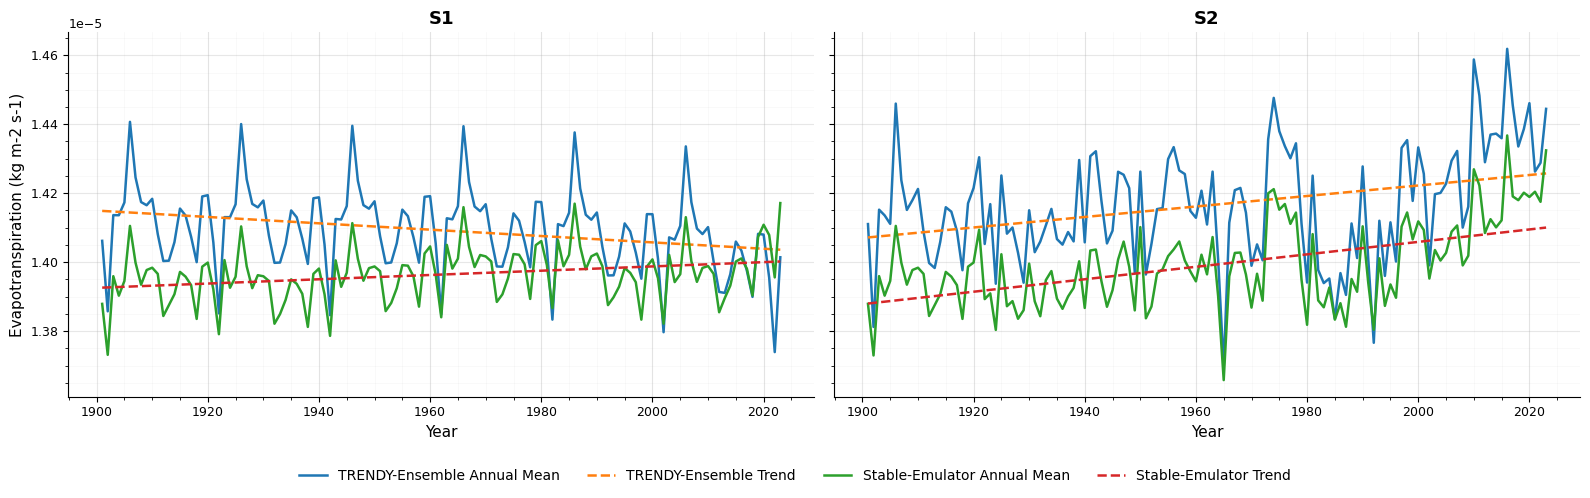

In [11]:
fig, axes = plot_two_scenarios(
    ensmean_S1_evapotrans_annual_mean, ensmean_S1_evapotrans_trend, ens_S1_evapotrans_line,
    stable_S1_evapotrans_annual_mean, stable_S1_evapotrans_trend, stb_S1_evapotrans_line,
    ensmean_S2_evapotrans_annual_mean, ensmean_S2_evapotrans_trend, ens_S2_evapotrans_line,
    stable_S2_evapotrans_annual_mean, stable_S2_evapotrans_trend, stb_S2_evapotrans_line,
    var_label="Evapotranspiration",
    units="kg m-2 s-1",
    scen_labels=("S1", "S2"),
)

plt.show()

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

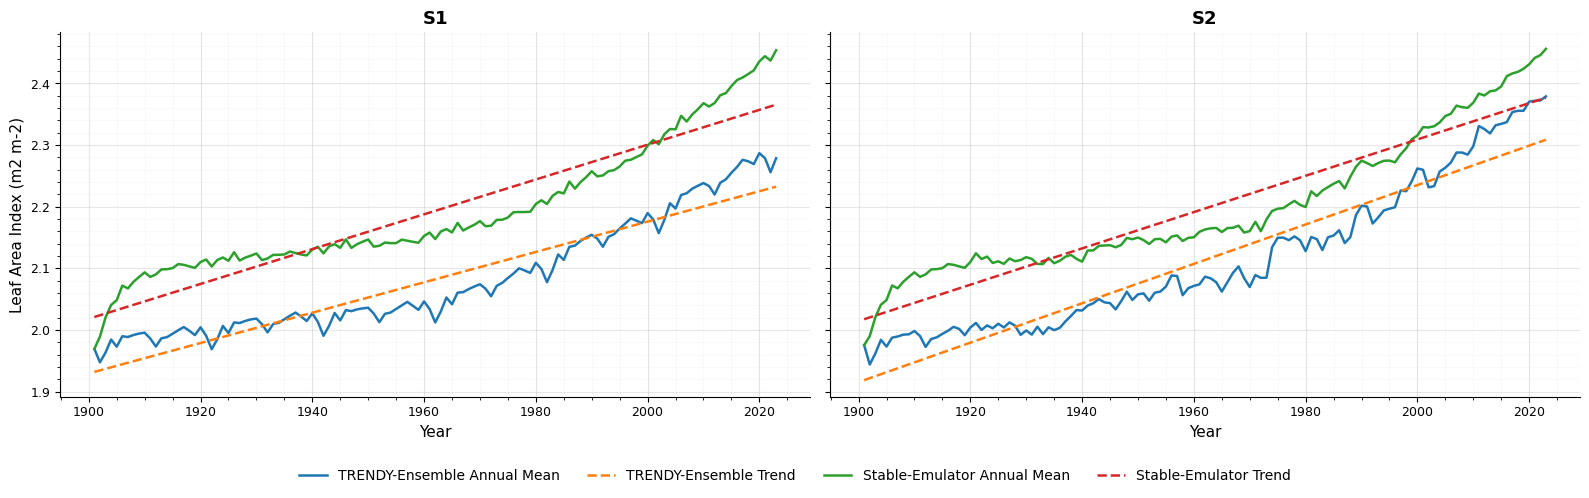

In [12]:
# load lai
ensmean_S1_lai_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/trend_1D/lai_trend_1D.nc")
ensmean_S2_lai_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/trend_1D/lai_trend_1D.nc")
ensmean_S1_lai_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/iav_1D/lai_iav_1D.nc")    
ensmean_S2_lai_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/iav_1D/lai_iav_1D.nc")
ensmean_S1_lai_annual_mean = reconstruct_annual_mean(ensmean_S1_lai_trend, ensmean_S1_lai_iav, start_year=1901)
ensmean_S2_lai_annual_mean = reconstruct_annual_mean(ensmean_S2_lai_trend, ensmean_S2_lai_iav, start_year=1901)

stable_S1_lai_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/trend_1D/lai_trend_1D.nc")
stable_S2_lai_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/trend_1D/lai_trend_1D.nc")
stable_S1_lai_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/iav_1D/lai_iav_1D.nc")    
stable_S2_lai_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/iav_1D/lai_iav_1D.nc")
stable_S1_lai_annual_mean = reconstruct_annual_mean(stable_S1_lai_trend, stable_S1_lai_iav, start_year=1901)
stable_S2_lai_annual_mean = reconstruct_annual_mean(stable_S2_lai_trend, stable_S2_lai_iav, start_year=1901)

# Build trend lines for each
ens_S1_lai_line = trend_line_on_time(ensmean_S1_lai_trend, ensmean_S1_lai_annual_mean)
ens_S2_lai_line = trend_line_on_time(ensmean_S2_lai_trend, ensmean_S2_lai_annual_mean)
stb_S1_lai_line = trend_line_on_time(stable_S1_lai_trend, stable_S1_lai_annual_mean)
stb_S2_lai_line = trend_line_on_time(stable_S2_lai_trend, stable_S2_lai_annual_mean)

fig, axes = plot_two_scenarios(
    ensmean_S1_lai_annual_mean, ensmean_S1_lai_trend, ens_S1_lai_line,
    stable_S1_lai_annual_mean, stable_S1_lai_trend, stb_S1_lai_line,
    ensmean_S2_lai_annual_mean, ensmean_S2_lai_trend, ens_S2_lai_line,
    stable_S2_lai_annual_mean, stable_S2_lai_trend, stb_S2_lai_line,
    var_label="Leaf Area Index",
    units="m2 m-2",
    scen_labels=("S1", "S2"),
)

plt.show()

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

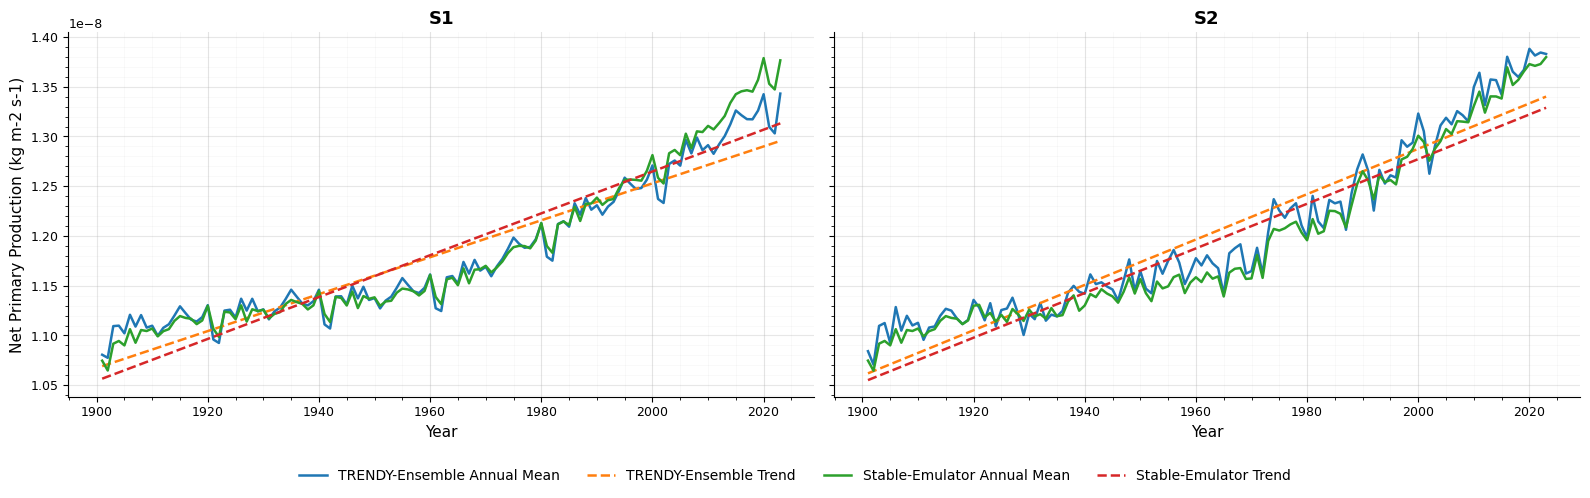

In [13]:
# load npp
ensmean_S1_npp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/trend_1D/npp_trend_1D.nc")
ensmean_S2_npp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/trend_1D/npp_trend_1D.nc")
ensmean_S1_npp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/iav_1D/npp_iav_1D.nc")    
ensmean_S2_npp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/iav_1D/npp_iav_1D.nc")
ensmean_S1_npp_annual_mean = reconstruct_annual_mean(ensmean_S1_npp_trend, ensmean_S1_npp_iav, start_year=1901)
ensmean_S2_npp_annual_mean = reconstruct_annual_mean(ensmean_S2_npp_trend, ensmean_S2_npp_iav, start_year=1901)

stable_S1_npp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/trend_1D/npp_trend_1D.nc")
stable_S2_npp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/trend_1D/npp_trend_1D.nc")
stable_S1_npp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/iav_1D/npp_iav_1D.nc")    
stable_S2_npp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/iav_1D/npp_iav_1D.nc")
stable_S1_npp_annual_mean = reconstruct_annual_mean(stable_S1_npp_trend, stable_S1_npp_iav, start_year=1901)
stable_S2_npp_annual_mean = reconstruct_annual_mean(stable_S2_npp_trend, stable_S2_npp_iav, start_year=1901)

# Build trend lines for each
ens_S1_npp_line = trend_line_on_time(ensmean_S1_npp_trend, ensmean_S1_npp_annual_mean)
ens_S2_npp_line = trend_line_on_time(ensmean_S2_npp_trend, ensmean_S2_npp_annual_mean)
stb_S1_npp_line = trend_line_on_time(stable_S1_npp_trend, stable_S1_npp_annual_mean)
stb_S2_npp_line = trend_line_on_time(stable_S2_npp_trend, stable_S2_npp_annual_mean)

fig, axes = plot_two_scenarios(
    ensmean_S1_npp_annual_mean, ensmean_S1_npp_trend, ens_S1_npp_line,
    stable_S1_npp_annual_mean, stable_S1_npp_trend, stb_S1_npp_line,
    ensmean_S2_npp_annual_mean, ensmean_S2_npp_trend, ens_S2_npp_line,
    stable_S2_npp_annual_mean, stable_S2_npp_trend, stb_S2_npp_line,
    var_label="Net Primary Production",
    units="kg m-2 s-1",
    scen_labels=("S1", "S2"),
)

plt.show()

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

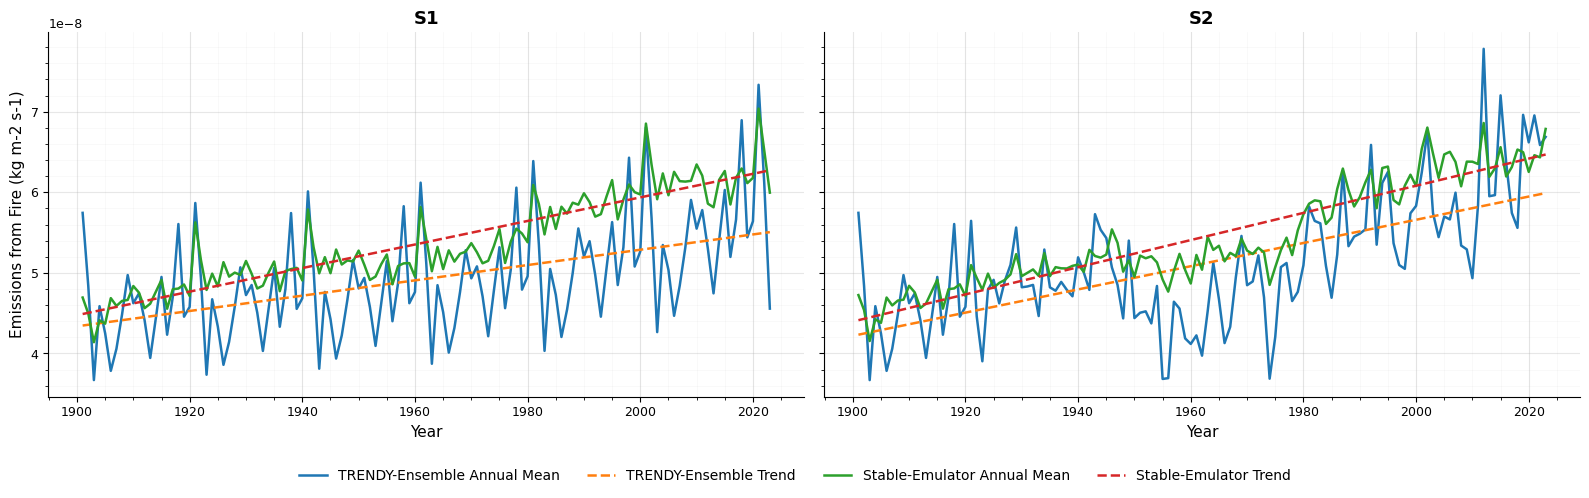

In [ ]:
# load nbp
ensmean_S1_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/trend_1D/nbp_trend_1D.nc")
ensmean_S2_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/trend_1D/nbp_trend_1D.nc")
ensmean_S1_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S1/iav_1D/nbp_iav_1D.nc")    
ensmean_S2_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/iav_1D/nbp_iav_1D.nc")
ensmean_S1_nbp_annual_mean = reconstruct_annual_mean(ensmean_S1_nbp_trend, ensmean_S1_nbp_iav, start_year=1901)
ensmean_S2_nbp_annual_mean = reconstruct_annual_mean(ensmean_S2_nbp_trend, ensmean_S2_nbp_iav, start_year=1901)

stable_S1_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/trend_1D/nbp_trend_1D.nc")
stable_S2_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/trend_1D/nbp_trend_1D.nc")
stable_S1_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S1/full/iav_1D/nbp_iav_1D.nc")    
stable_S2_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/iav_1D/nbp_iav_1D.nc")
stable_S1_nbp_annual_mean = reconstruct_annual_mean(stable_S1_nbp_trend, stable_S1_nbp_iav, start_year=1901)
stable_S2_nbp_annual_mean = reconstruct_annual_mean(stable_S2_nbp_trend, stable_S2_nbp_iav, start_year=1901)

# Build trend lines for each
ens_S1_nbp_line = trend_line_on_time(ensmean_S1_nbp_trend, ensmean_S1_nbp_annual_mean)
ens_S2_nbp_line = trend_line_on_time(ensmean_S2_nbp_trend, ensmean_S2_nbp_annual_mean)
stb_S1_nbp_line = trend_line_on_time(stable_S1_nbp_trend, stable_S1_nbp_annual_mean)
stb_S2_nbp_line = trend_line_on_time(stable_S2_nbp_trend, stable_S2_nbp_annual_mean)

fig, axes = plot_two_scenarios(
    ensmean_S1_nbp_annual_mean, ensmean_S1_nbp_trend, ens_S1_nbp_line,
    stable_S1_nbp_annual_mean, stable_S1_nbp_trend, stb_S1_nbp_line,
    ensmean_S2_nbp_annual_mean, ensmean_S2_nbp_trend, ens_S2_nbp_line,
    stable_S2_nbp_annual_mean, stable_S2_nbp_trend, stb_S2_nbp_line,
    var_label="Emissions from Fire",
    units="kg m-2 s-1",
    scen_labels=("S1", "S2"),
)

plt.show()

# S2-S3

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

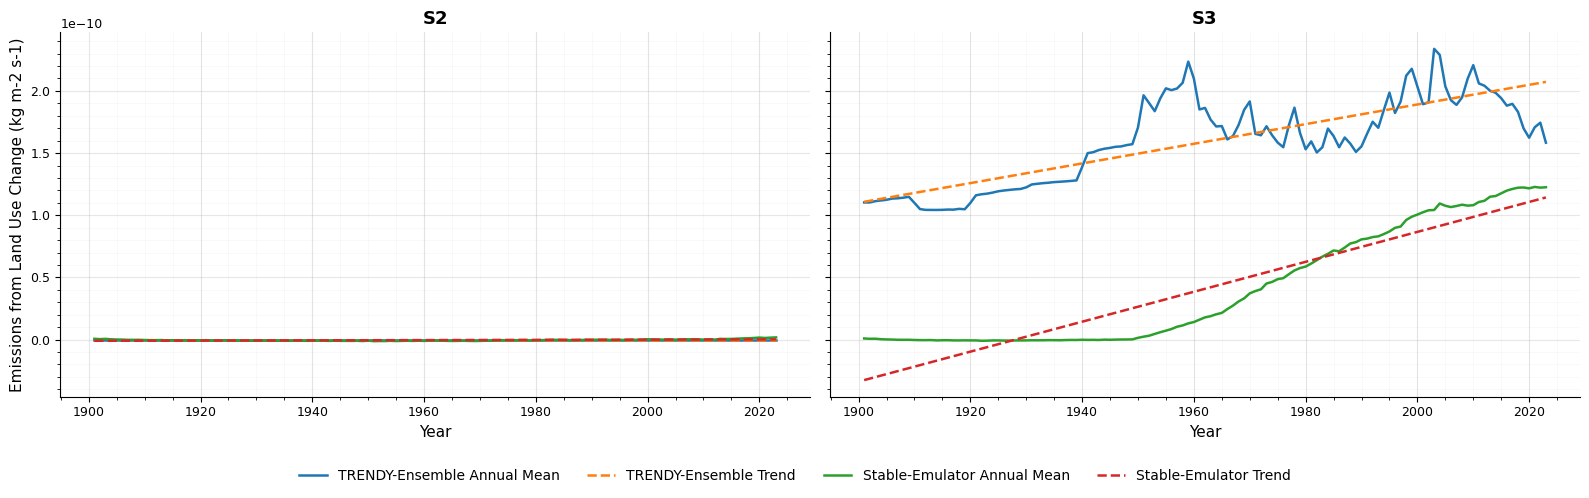

In [15]:
# load fLuc
ensmean_S2_fLuc_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/trend_1D/fLuc_trend_1D.nc")
ensmean_S3_fLuc_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S3/trend_1D/fLuc_trend_1D.nc")
ensmean_S2_fLuc_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/iav_1D/fLuc_iav_1D.nc")    
ensmean_S3_fLuc_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S3/iav_1D/fLuc_iav_1D.nc")
ensmean_S2_fLuc_annual_mean = reconstruct_annual_mean(ensmean_S2_fLuc_trend, ensmean_S2_fLuc_iav, start_year=1901)
ensmean_S3_fLuc_annual_mean = reconstruct_annual_mean(ensmean_S3_fLuc_trend, ensmean_S3_fLuc_iav, start_year=1901)

stable_S2_fLuc_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/trend_1D/fLuc_trend_1D.nc")
stable_S3_fLuc_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S3/trend_1D/fLuc_trend_1D.nc")
stable_S2_fLuc_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/iav_1D/fLuc_iav_1D.nc")    
stable_S3_fLuc_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S3/iav_1D/fLuc_iav_1D.nc")
stable_S2_fLuc_annual_mean = reconstruct_annual_mean(stable_S2_fLuc_trend, stable_S2_fLuc_iav, start_year=1901)
stable_S3_fLuc_annual_mean = reconstruct_annual_mean(stable_S3_fLuc_trend, stable_S3_fLuc_iav, start_year=1901)

# Build trend lines for each
ens_S2_fLuc_line = trend_line_on_time(ensmean_S2_fLuc_trend, ensmean_S2_fLuc_annual_mean)
ens_S3_fLuc_line = trend_line_on_time(ensmean_S3_fLuc_trend, ensmean_S3_fLuc_annual_mean)
stb_S2_fLuc_line = trend_line_on_time(stable_S2_fLuc_trend, stable_S2_fLuc_annual_mean)
stb_S3_fLuc_line = trend_line_on_time(stable_S3_fLuc_trend, stable_S3_fLuc_annual_mean)

fig, axes = plot_two_scenarios(
    ensmean_S2_fLuc_annual_mean, ensmean_S2_fLuc_trend, ens_S2_fLuc_line,
    stable_S2_fLuc_annual_mean, stable_S2_fLuc_trend, stb_S2_fLuc_line,
    ensmean_S3_fLuc_annual_mean, ensmean_S3_fLuc_trend, ens_S3_fLuc_line,
    stable_S3_fLuc_annual_mean, stable_S3_fLuc_trend, stb_S3_fLuc_line,
    var_label="Emissions from Land Use Change",
    units="kg m-2 s-1",
    scen_labels=("S2", "S3"),
)

plt.show()

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

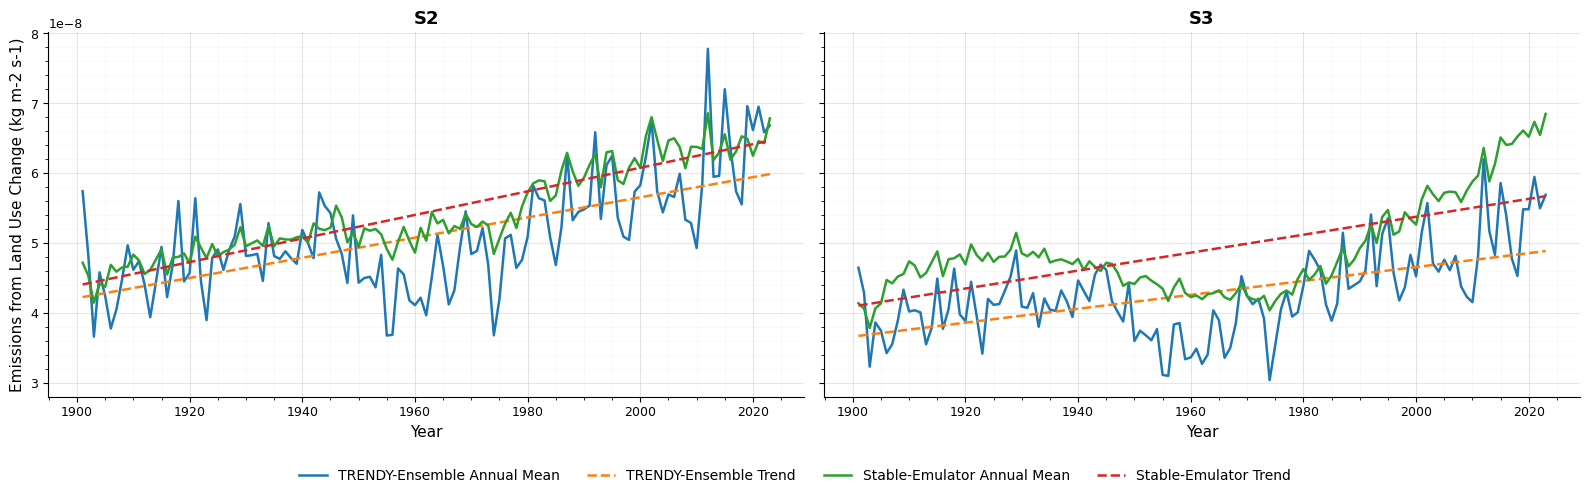

In [ ]:
# load nbp
ensmean_S2_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/trend_1D/nbp_trend_1D.nc")
ensmean_S3_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S3/trend_1D/nbp_trend_1D.nc")
ensmean_S2_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/iav_1D/nbp_iav_1D.nc")    
ensmean_S3_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S3/iav_1D/nbp_iav_1D.nc")
ensmean_S2_nbp_annual_mean = reconstruct_annual_mean(ensmean_S2_nbp_trend, ensmean_S2_nbp_iav, start_year=1901)
ensmean_S3_nbp_annual_mean = reconstruct_annual_mean(ensmean_S3_nbp_trend, ensmean_S3_nbp_iav, start_year=1901)

stable_S2_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/trend_1D/nbp_trend_1D.nc")
stable_S3_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S3/trend_1D/nbp_trend_1D.nc")
stable_S2_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/iav_1D/nbp_iav_1D.nc")    
stable_S3_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S3/iav_1D/nbp_iav_1D.nc")
stable_S2_nbp_annual_mean = reconstruct_annual_mean(stable_S2_nbp_trend, stable_S2_nbp_iav, start_year=1901)
stable_S3_nbp_annual_mean = reconstruct_annual_mean(stable_S3_nbp_trend, stable_S3_nbp_iav, start_year=1901)

# Build trend lines for each
ens_S2_nbp_line = trend_line_on_time(ensmean_S2_nbp_trend, ensmean_S2_nbp_annual_mean)
ens_S3_nbp_line = trend_line_on_time(ensmean_S3_nbp_trend, ensmean_S3_nbp_annual_mean)
stb_S2_nbp_line = trend_line_on_time(stable_S2_nbp_trend, stable_S2_nbp_annual_mean)
stb_S3_nbp_line = trend_line_on_time(stable_S3_nbp_trend, stable_S3_nbp_annual_mean)

fig, axes = plot_two_scenarios(
    ensmean_S2_nbp_annual_mean, ensmean_S2_nbp_trend, ens_S2_nbp_line,
    stable_S2_nbp_annual_mean, stable_S2_nbp_trend, stb_S2_nbp_line,
    ensmean_S3_nbp_annual_mean, ensmean_S3_nbp_trend, ens_S3_nbp_line,
    stable_S3_nbp_annual_mean, stable_S3_nbp_trend, stb_S3_nbp_line,
    var_label="Emissions from Fire",
    units="kg m-2 s-1",
    scen_labels=("S2", "S3"),
)

plt.show()

/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  annual_mean = annual_mean.assign_coords(time=dt)
/tmp/ipykernel_94766/960552116.py:41: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

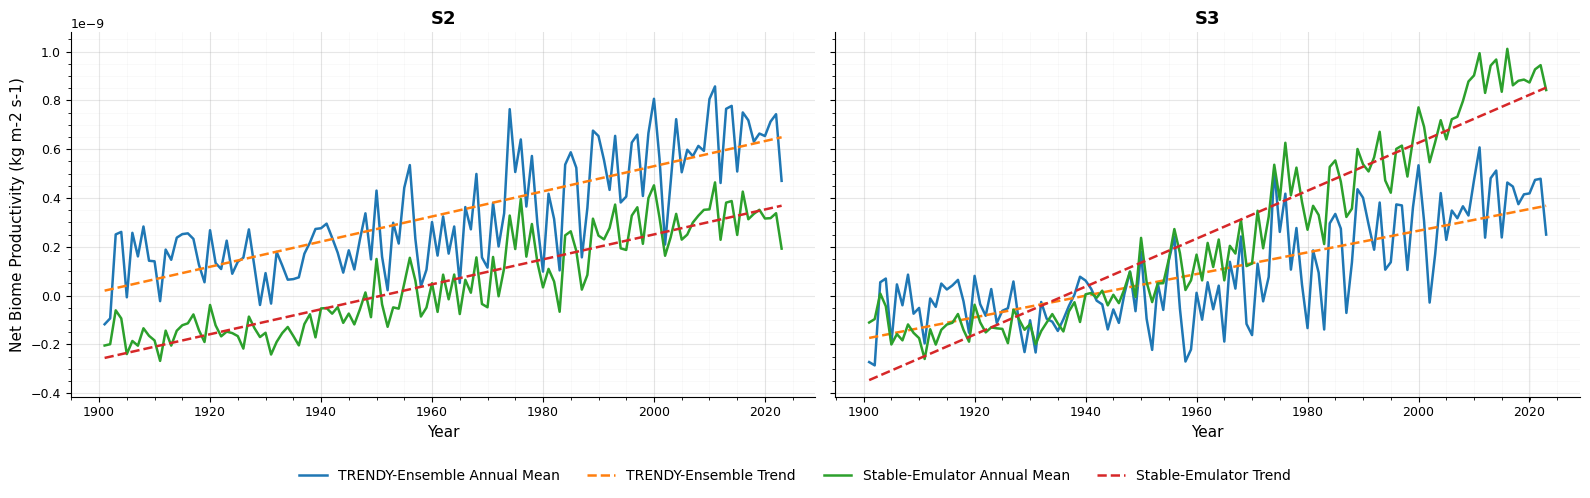

In [17]:
# load nbp
ensmean_S2_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/trend_1D/nbp_trend_1D.nc")
ensmean_S3_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S3/trend_1D/nbp_trend_1D.nc")
ensmean_S2_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S2/iav_1D/nbp_iav_1D.nc")    
ensmean_S3_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/ensmean/S3/iav_1D/nbp_iav_1D.nc")
ensmean_S2_nbp_annual_mean = reconstruct_annual_mean(ensmean_S2_nbp_trend, ensmean_S2_nbp_iav, start_year=1901)
ensmean_S3_nbp_annual_mean = reconstruct_annual_mean(ensmean_S3_nbp_trend, ensmean_S3_nbp_iav, start_year=1901)

stable_S2_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/trend_1D/nbp_trend_1D.nc")
stable_S3_nbp_trend = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S3/trend_1D/nbp_trend_1D.nc")
stable_S2_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S2/full/iav_1D/nbp_iav_1D.nc")    
stable_S3_nbp_iav = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/analysis/metrics/Stable-Emulator/S3/iav_1D/nbp_iav_1D.nc")
stable_S2_nbp_annual_mean = reconstruct_annual_mean(stable_S2_nbp_trend, stable_S2_nbp_iav, start_year=1901)
stable_S3_nbp_annual_mean = reconstruct_annual_mean(stable_S3_nbp_trend, stable_S3_nbp_iav, start_year=1901)

# Build trend lines for each
ens_S2_nbp_line = trend_line_on_time(ensmean_S2_nbp_trend, ensmean_S2_nbp_annual_mean)
ens_S3_nbp_line = trend_line_on_time(ensmean_S3_nbp_trend, ensmean_S3_nbp_annual_mean)
stb_S2_nbp_line = trend_line_on_time(stable_S2_nbp_trend, stable_S2_nbp_annual_mean)
stb_S3_nbp_line = trend_line_on_time(stable_S3_nbp_trend, stable_S3_nbp_annual_mean)

fig, axes = plot_two_scenarios(
    ensmean_S2_nbp_annual_mean, ensmean_S2_nbp_trend, ens_S2_nbp_line,
    stable_S2_nbp_annual_mean, stable_S2_nbp_trend, stb_S2_nbp_line,
    ensmean_S3_nbp_annual_mean, ensmean_S3_nbp_trend, ens_S3_nbp_line,
    stable_S3_nbp_annual_mean, stable_S3_nbp_trend, stb_S3_nbp_line,
    var_label="Net Biome Productivity",
    units="kg m-2 s-1",
    scen_labels=("S2", "S3"),
)

plt.show()